In [ ]:
from google.colab import drive
drive.mount("/content/drive")
import os
os.chdir("/content/drive/MyDrive/BERT")
!pip install transformers
from transformers import AutoTokenizer
import re
import pandas as pd
import numpy as np
import random
import torch
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from matplotlib import pyplot as plt

# Read data

In [4]:
train_dataset = pd.read_csv("dataset_original.csv")
train_data = train_dataset["data"].values
train_label = train_dataset["label"].values

test_dataset = pd.read_csv("test_file.csv")
test_data = test_dataset["data"].values
test_label = test_dataset["label"].values

In [6]:
data = list(train_data) + list(test_data)
label = list(train_label) + list(test_label) 

# Tokenzie data with pretrained phobert

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

In [10]:
def encode_data(data, tokenizer):
  result = []
  for text in tqdm(data, total=len(data)):
    temp = tokenizer.encode(text)
    result.append(temp)
  return result

In [11]:
tokenized_data = encode_data(data, tokenizer)

100%|██████████| 185616/185616 [00:50<00:00, 3648.44it/s]


In [14]:
len_data = [len(text) for text in tokenized_data]

# Analyze data


*   Data length
*   Vocab size






In [89]:
def calculate_length(data, label):
  dict_ = {}
  for ind, text in tqdm(enumerate(data), total=len(data)):
    if label[ind] in dict_.keys():
      dict_[label[ind][:-4]].append(len(text))
    else:
      dict_[label[ind][:-4]] = [len(text)]
  return dict_

In [90]:
length_for_classes = calculate_length(tokenized_data, label)

100%|██████████| 185616/185616 [00:00<00:00, 994599.77it/s]


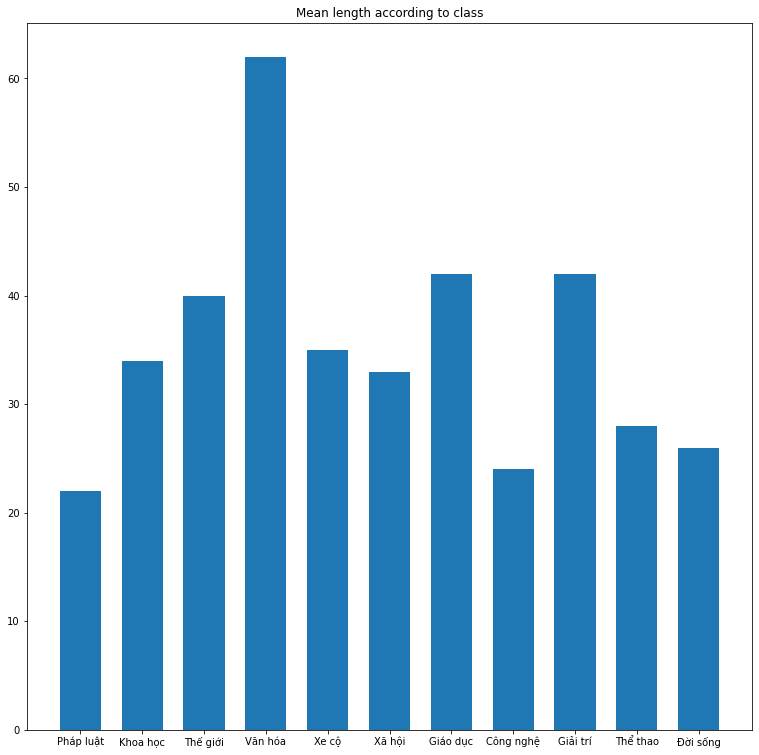

In [93]:
fig = plt.figure(figsize=(13,13))
ax = fig.subplots()
ax.bar(np.arange(11)*1.5, [np.mean(value) for value in length_for_classes.values()], width=1)
ax.set_xticks(np.arange(11)*1.5)
ax.set_xticklabels(length_for_classes.keys(), minor=False)
ax.set_title("Mean length according to class")
plt.show()

Obviously, "Văn hóa" is the class having largest mean length of texts. That means, overral, articles about "Văn hóa" is long than others. Meanwhile, "Pháp luật" and "Công nghệ"'s news are much shorter than others. 

In [94]:
length_data = [len(text) for text in tokenized_data]

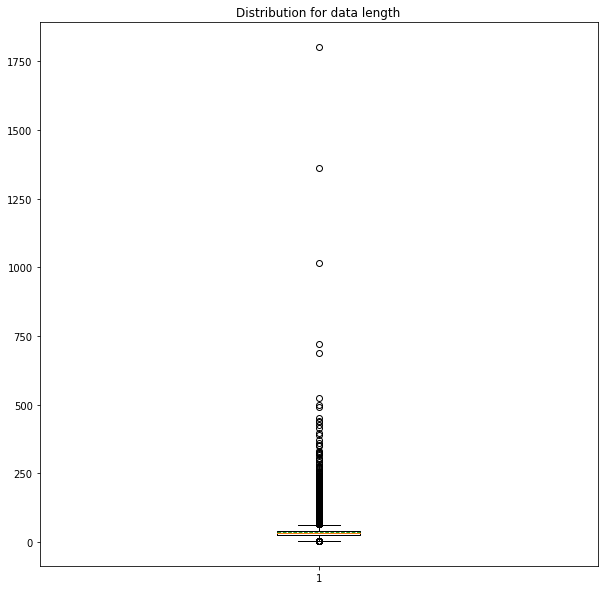

In [98]:
fig = plt.figure(figsize=(10,10))
ax = fig.subplots()
ax.boxplot(length_data, showfliers=True, showmeans=True, meanline=True)
ax.set_title("Distribution for data length")
plt.show()

Take a glance at above diagram, it is clearly that this dataset almost contains short texts. However, it has nontrivial number of sample having length outside of ..., which may leads to noise in training process. Let take more detailed analysis on it. The bar chart is used to show the quantity of texts of lengths in each interval, with an interval magnitude of 100.

In [106]:
intervals = ['0-100', '100-200', '200-300', '300-400','400-500', '500-600', '600-700', '700-800', '800-900', '900-1000', '1000-1100', '1100-1200', '1200-1300', '1300-1400', '1400-1500', '1500-1600', '1600-1700', '1700-1800', '1800-1900']
number_texts = [0] * len(intervals)
dict_2 = {}
for item in tqdm(length_data, total=len(length_data)):
    number_texts[item // 100] += 1

100%|██████████| 185616/185616 [00:00<00:00, 1877894.36it/s]


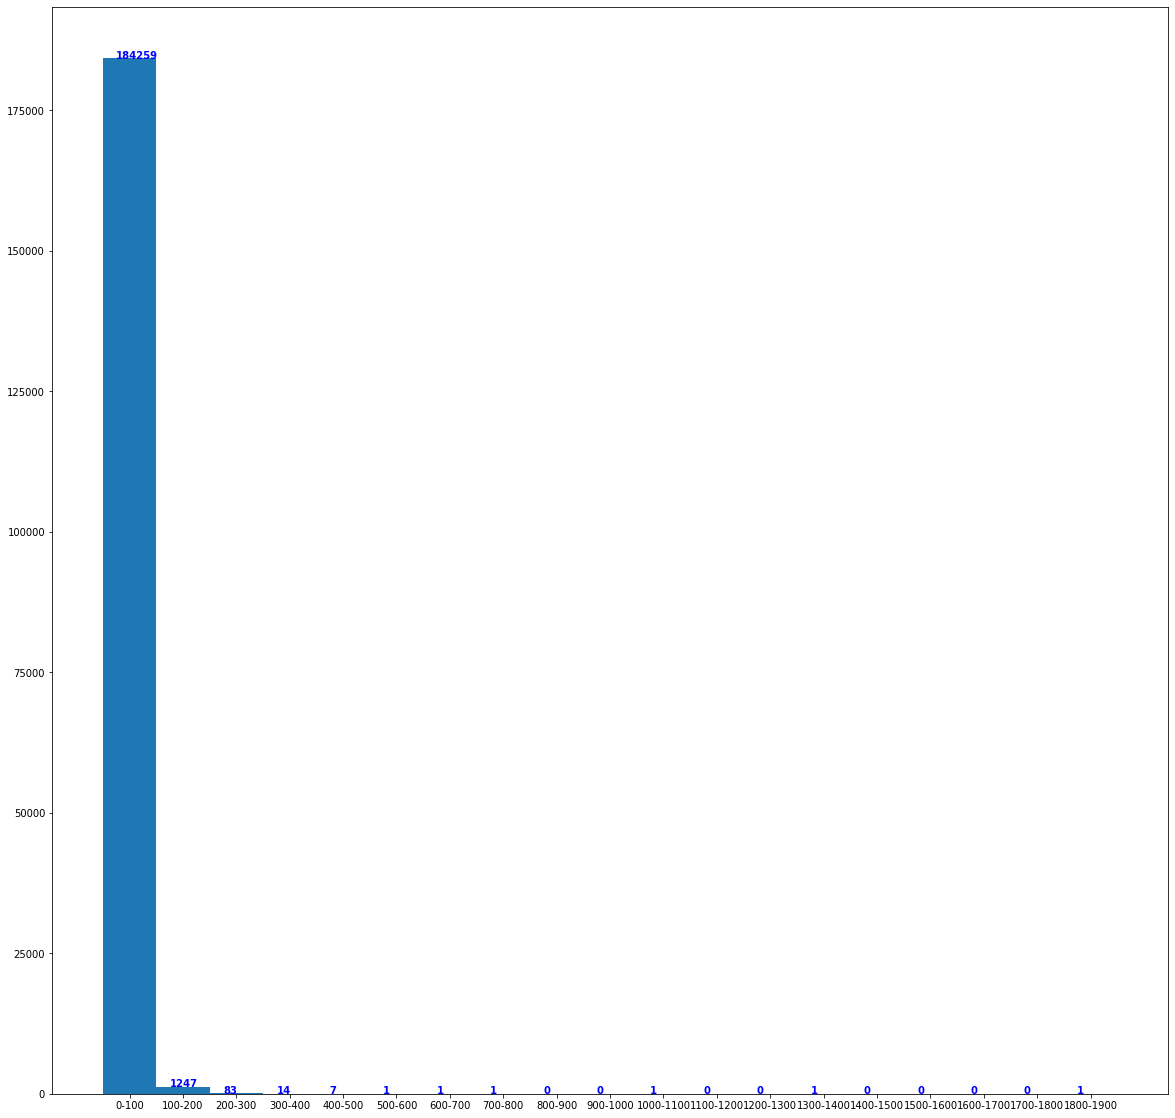

In [114]:
fig = plt.figure(figsize=(20,20))
ax = fig.subplots()
ax.bar(np.arange(len(intervals))*2, number_texts, 2)
ax.set_xticks(np.arange(len(intervals))*2)
ax.set_xticklabels(intervals, minor=False)
for i, v in enumerate(number_texts):
  ax.text(i*2-0.5, v + 2, str(v),color='blue', fontweight='bold')
plt.show()

As you can see, most data sample has length less than 100. Nontrivial amount of texts have length in range from 100 to 200. Whereas, other intervals has footling number of texts.
# Proposal
It is resonable to set sequence length to 128 in training process.